In [3]:
# !pip install mlxtend
# !pip install tqdm
# !pip install numba

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [2]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [3]:
import numpy as np
import numba
import pandas as pd
import warnings
from tqdm.auto import tqdm
from itertools import combinations, product

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

whole_df = pd.read_csv("../comp_files/train.csv")
whole_df.shape

/home/nlztrk/anaconda3/envs/optiver/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(5237980, 17)

In [4]:
def tidy_up_df(hdf,
              target_dateid=False,
              target_second=False):
    
    # Chronological sorting
    hdf = hdf.sort_values(by=["stock_id",
                            "date_id",
                            "seconds_in_bucket"],
                        ascending=True).reset_index(drop=True)

    # Adding missing rows by reindexing
    all_stock_ids = np.arange(0., 200., 1.)
    all_seconds = np.arange(0., 550., 10.)
    all_date_ids = list(hdf["date_id"].unique())
    ideal_group_ids = list(product(all_stock_ids, all_date_ids, all_seconds))

    hdf = hdf.set_index(["stock_id","date_id","seconds_in_bucket"])
    hdf = hdf.reindex(ideal_group_ids).reset_index()
    
    # Chronological sorting on imputed data
    hdf = hdf.sort_values(by=["stock_id",
                            "date_id",
                            "seconds_in_bucket"],
                        ascending=True).reset_index(drop=True)
    
    # Creating row_id for new added rows, will be used on prediction merging @ inference phase
    # row_id = date_id _ seconds_in_bucket _ stock_id
    missing_row_idxs = hdf.row_id.isna()

    hdf.loc[missing_row_idxs, "row_id"] = hdf.loc[missing_row_idxs, "date_id"].astype(int).astype(str) + "_" +\
                            hdf.loc[missing_row_idxs, "seconds_in_bucket"].astype(int).astype(str) + "_" +\
                            hdf.loc[missing_row_idxs, "stock_id"].astype(int).astype(str)    
    
    # Will be used on inference stage
    if target_dateid or target_second:
        hdf = hdf[(hdf["date_id"] == target_dateid) &\
                  (hdf["seconds_in_bucket"] == target_second)].reset_index(drop=True)
    
    return hdf

In [5]:
whole_df = tidy_up_df(whole_df)

In [6]:
whole_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

### CV Scheme

In [7]:
whole_df['fold1'] = np.nan
whole_df.loc[whole_df['date_id'] < 240, 'fold1'] = 0
whole_df.loc[(whole_df['date_id'] >= 240) & (whole_df['date_id'] < 300), 'fold1'] = 1

whole_df['fold2'] = np.nan
whole_df.loc[whole_df['date_id'] < 300, 'fold2'] = 0
whole_df.loc[(whole_df['date_id'] >= 300) & (whole_df['date_id'] < 360), 'fold2'] = 1

whole_df['fold3'] = np.nan
whole_df.loc[whole_df['date_id'] < 360, 'fold3'] = 0
whole_df.loc[(whole_df['date_id'] >= 360) & (whole_df['date_id'] < 420), 'fold3'] = 1

whole_df['fold4'] = np.nan
whole_df.loc[whole_df['date_id'] < 420, 'fold4'] = 0
whole_df.loc[(whole_df['date_id'] >= 420) & (whole_df['date_id'] < 481), 'fold4'] = 1

In [8]:
stock_weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

In [9]:
def arithmetic_generator(inp_df, inp_cols):
    for (col1, col2) in tqdm(list(combinations(inp_cols, 2)), desc=f"Generating arithmetics (n,2) for: {inp_cols}"):    
        inp_df[f"{col1}_diff_{col2}"] = (inp_df[f"{col1}"] - inp_df[f"{col2}"]).astype(np.float32)
        inp_df[f"{col1}_sum_{col2}"] = (inp_df[f"{col1}"] + inp_df[f"{col2}"]).astype(np.float32)
        inp_df[f"{col1}_ratio_{col2}"] = (inp_df[f"{col1}"] / inp_df[f"{col2}"]).astype(np.float32)
#         inp_df[f"{col1}_mult_{col2}"] = (inp_df[f"{col1}"] * inp_df[f"{col2}"]).astype(np.float32)
        
    return inp_df

In [10]:
drop_cols = [
    'date_id',
    'row_id',
    'time_id',
    'target',
    
    'fold1',
    'fold2',
    'fold3',
    'fold4',
    
    "last_matched_size",
    'currently_scored'
                 ]

nonpct_cols = drop_cols + [
    'stock_id',
    'seconds_in_bucket',
    'matched_diff_date',
    'day_of_week'
                 ]

original_f32_cols = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target']

In [11]:
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def run_anil_pipe(df, kaggle_mode=False):

    if kaggle_mode:
        df[original_f32_cols] = df[original_f32_cols].astype(np.float32)
    else:
        for col in original_f32_cols:
            df[col] = df[col].astype(np.float32)
            
    # Index features with raw prices
    df["stock_weight"] = df["stock_id"].astype(int).apply(lambda x: stock_weights[x]).astype(np.float32)
    df["weighted_wap"] = (df["stock_weight"] * df["wap"]).astype(np.float32)
    df = df.merge(df.groupby(["date_id", "seconds_in_bucket"])["weighted_wap"].sum()\
                              .rename("index_coeff").astype(np.float32).reset_index(),
                             how="left",
                             on=["date_id", "seconds_in_bucket"])    

    df['wap_index_ratio'] = df.eval("wap / index_coeff").astype(np.float32)
    df['wap_index_diff'] = df.eval("wap - index_coeff").astype(np.float32)
    #

    
    # Price Normalization
    for col in df.columns:
        if ("price" in col or col in ["wap", "weighted_wap"]) and col != "reference_price":
            df[col] /= df["reference_price"]
        
    df["imbalance"] = (df["imbalance_size"] * df["imbalance_buy_sell_flag"]).astype(np.float32)
    df["day_of_week"] = (df["date_id"] % 5).astype(np.float32)
    
    # Intra-day second-specific Features
    intraday_cols = ['imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target']
    
    for day_offset in [1]:
        df[[f"{col}_dayoffset{day_offset}_shifted" for col in intraday_cols]] =\
            df.groupby(["stock_id"])[intraday_cols].shift(day_offset*55).astype(np.float32)
        
    # Last Day Comparisons
    stock_date_idxs = df.groupby(["stock_id", "date_id"])["matched_size"].last().index
    #
    current_day_start_match_size = df.groupby(["stock_id", "date_id"])["matched_size"].first()\
            .rename("start_of_the_day_matched_size").reset_index()
    df = df.merge(current_day_start_match_size, how="left", on=["stock_id", "date_id"])
    del current_day_start_match_size
    #                                                
    current_day_start_imbalance = df.groupby(["stock_id", "date_id"])["imbalance"].first()\
            .rename("current_day_start_imbalance").reset_index()
    df = df.merge(current_day_start_imbalance, how="left", on=["stock_id", "date_id"]) 
    del current_day_start_imbalance
    #                                               
    last_day_ending_match_size = pd.DataFrame(df.groupby(["stock_id", "date_id"])["matched_size"].last()\
            .reset_index().groupby(["stock_id"])["matched_size"].shift()\
            .rename("last_day_ending_match_size")).set_index(stock_date_idxs).reset_index()
    df = df.merge(last_day_ending_match_size, how="left", on=["stock_id", "date_id"])
    del last_day_ending_match_size
    #    
    last_day_ending_imbalance = pd.DataFrame(df.groupby(["stock_id", "date_id"])["imbalance"].last()\
            .reset_index().groupby(["stock_id"])["imbalance"].shift()\
            .rename("last_day_ending_imbalance")).set_index(stock_date_idxs).reset_index()
    df = df.merge(last_day_ending_imbalance, how="left", on=["stock_id", "date_id"])
    del last_day_ending_imbalance
    
    del stock_date_idxs
    
    #
    df["matched_diff_date"] = df["start_of_the_day_matched_size"] - df["last_day_ending_match_size"]
    df["matched_ratio_date"] = df["start_of_the_day_matched_size"] / df["last_day_ending_match_size"]
    
    df["current_matched_diff_date"] = df["matched_size"] - df["last_day_ending_match_size"]
    df["current_matched_ratio_date"] = df["matched_size"] / df["last_day_ending_match_size"]
    
    df["imbalance_diff_date"] = df["current_day_start_imbalance"] - df["last_day_ending_imbalance"]
    df["imbalance_ratio_date"] = df["current_day_start_imbalance"] / df["last_day_ending_imbalance"]
    
    df["current_imbalance_diff_date"] = df["imbalance"] - df["last_day_ending_imbalance"]
    df["current_imbalance_ratio_date"] = df["imbalance"] / df["last_day_ending_imbalance"]                     
    

    ###########
    # https://www.kaggle.com/code/nyanpn/1st-place-public-2nd-place-solution
    
    for col in ["wap", "ask_price", "bid_price"]:
        df[f'log_{col}'] = np.log(df[col])
        df[f'log_return_{col}'] = df.groupby(["stock_id", "date_id"])[f'log_{col}']\
            .diff().astype(np.float32).values
        df.drop(columns=[f'log_{col}'], axis=1, inplace=True)
        
        df[f'log_return_{col}_sq'] = df[f'log_return_{col}'] ** 2
        df[f'log_return_{col}_realized_volatility'] = df.groupby(["stock_id", "date_id"])[f'log_return_{col}_sq'].expanding().\
                sum().astype(np.float32).values
        df[f'log_return_{col}_realized_volatility'] = np.sqrt(df[f'log_return_{col}_realized_volatility'])
        df.drop(columns=[f'log_return_{col}_sq'], axis=1, inplace=True)
    
    ###########
    
    
    df['bid_price_diff_ask_price'] = df.eval("bid_price - ask_price").astype(np.float32)
    df['bid_price_sum_ask_price'] = df.eval("bid_price + ask_price").astype(np.float32)
    df['bid_size_sum_ask_size'] = df.eval("bid_size + ask_size").astype(np.float32)

    df["volume"] = df.eval("ask_size + bid_size").astype(np.float32)
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2").astype(np.float32)
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)").astype(np.float32)
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)").astype(np.float32)
    df["size_imbalance"] = df.eval("bid_size / ask_size").astype(np.float32)

    df["wap_1st_nominator"] = df.eval("ask_size * bid_price").astype(np.float32)
    df["wap_2nd_nominator"] = df.eval("ask_price * bid_size").astype(np.float32)
    df["wap_whole_nominator"] = df.eval("wap_1st_nominator + wap_2nd_nominator").astype(np.float32)

    df["imbalance_momentum"] = (df.groupby(["stock_id", "date_id"])['imbalance_size'].diff(periods=1) \
                                / df['matched_size']).astype(np.float32)
    
    df["price_spread"] = (df["ask_price"] - df["bid_price"]).astype(np.float32)
    df["spread_intensity"] = df.groupby(["stock_id", "date_id"])['price_spread'].diff().astype(np.float32)
    df['price_pressure'] = (df['imbalance_size'] * (df['ask_price'] - df['bid_price'])).astype(np.float32)
    df['market_urgency'] = (df['price_spread'] * df['liquidity_imbalance']).astype(np.float32)
    df['depth_pressure'] = ((df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])).astype(np.float32)

    df['spread_depth_ratio'] = ((df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])).astype(np.float32)
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)).astype(np.float32)

    df['mid_price*volume'] = (df['mid_price_movement'] * df['volume']).astype(np.float32)
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))').astype(np.float32)

    # Linear combinations of both sizes and prices
    df['reverse_wap'] = df.eval('((bid_price * bid_size) + (ask_price * ask_size)) / (bid_size + ask_size)').astype(np.float32)

    # Liquidity Features
    df['bid_ask_spread_imbalance_interaction'] = (df['bid_price_diff_ask_price'] * df['imbalance_size']).astype(np.float32)
    df['bid_ask_spread_percentage'] = ((df['bid_price_diff_ask_price']) / ((df['bid_price_sum_ask_price']) / 2)).astype(np.float32)

    # WAP Rolling Features
    for period1 in [3,6,12]:
        df[f'wap_ema_{period1}'] = df.groupby(["stock_id", "date_id"])['wap'].rolling(period1).mean().astype(np.float32).values
        df[f'price_momentum_{period1}'] = (df['wap'] / df[f'wap_ema_{period1}'] - 1).astype(np.float32)
        df[f'wap_min_period{period1}'] = df.groupby(["stock_id", "date_id"])['wap'].rolling(period1).min().astype(np.float32).values
        df[f'wap_max_period{period1}'] = df.groupby(["stock_id", "date_id"])['wap'].rolling(period1).max().astype(np.float32).values
    
    df[f'wap_expanding_min'] = df.groupby(["stock_id", "date_id"])['wap'].expanding().min().astype(np.float32).values
    df[f'wap_expanding_max'] = df.groupby(["stock_id", "date_id"])['wap'].expanding().max().astype(np.float32).values


    # Price to Bid-Ask Ratio
    df['price_to_bid_ask_diff_ratio'] = (df['wap'] / df['bid_price_diff_ask_price']).astype(np.float32)

    # Spread-to-Volume Ratio
    df['spread_to_volume_ratio'] = (df['bid_price_diff_ask_price'] / df['matched_size']).astype(np.float32)

    # order_book_depth-to-Volume Ratio
    df['order_book_depth_to_matched_ratio'] = (df['bid_size_sum_ask_size'] / df['matched_size']).astype(np.float32)

    # Average Trade Size
    df['average_trade_size'] = (df['matched_size'] / (df['seconds_in_bucket'] + 1)).astype(np.float32)

    # Relative Spread
    df['relative_spread'] = (df['bid_price_diff_ask_price'] / df['wap']).astype(np.float32)

    
    df = df.drop(columns=["imbalance_size", "imbalance_buy_sell_flag"], axis=1)

        
    ################
    
    
    pctcols = list(set(df.columns).difference(nonpct_cols +\
                                              [f"{col}_dayoffset1_shifted" for col in intraday_cols] +\
                                             ["last_day_ending_match_size", "last_day_ending_imbalance"]))
    
    df[["allstocks_" + "_".join(elm) + "_pctrank" for elm in pctcols]] =\
        df.groupby(["date_id", "seconds_in_bucket"])[list(pctcols)]\
            .rank(pct=True).astype(np.float32)

    ################

    pctcols = list(set(df.columns).difference(nonpct_cols +\
                                             ["last_day_ending_match_size", "last_day_ending_imbalance"] +\
                                              [col for col in df.columns if "dayoffset" in col] +\
                                              [col for col in df.columns if "expanding" in col] +\
                                              [col for col in df.columns if "ema_" in col] +\
                                              [col for col in df.columns if "_period" in col] +\
                                              [col for col in df.columns if "momentum_" in col]
                                             )
                  )
    
    # Nested PCT Fest 2023
    for period1 in tqdm([1,3,6,12,18]):
        shifted_cols = df.groupby(["stock_id", "date_id"])[pctcols].shift(period1)
        df[[f"{pctcol}_period{period1}_diff" for pctcol in pctcols]] = (df[pctcols] - shifted_cols).astype(np.float32)
#         df[[f"{pctcol}_period{period1}_pct_change" for pctcol in pctcols]] = (df[pctcols] / shifted_cols - 1).astype(np.float32)
        del shifted_cols
        
    # Volatility Features
#     df['volatility'] = df.groupby(["stock_id", "date_id"])['wap_period1_pct_change'].rolling(window=rolling_window_size).std().astype(np.float32).values
    
    numerical_cols = list(set(df.columns).difference(["row_id", "currently_scored"]))
    
    if kaggle_mode:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df[numerical_cols] = df[numerical_cols].astype(np.float32)
    else:
        for col in numerical_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].astype(np.float32)
    
    return df

In [12]:
whole_df = run_anil_pipe(whole_df, kaggle_mode=False)

100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.54s/it]


In [13]:
len(whole_df.columns)

832

In [14]:
# whole_df = whole_df[whole_df["target"].notnull()].reset_index(drop=True)
whole_df.dropna(subset=["target"], inplace=True)
whole_df.reset_index(inplace=True, drop=True)

In [15]:
features = sorted(list(set(whole_df.columns).difference(drop_cols)))
target = "target"

In [16]:
xgb_param = {
  "learning_rate": 0.01,
  "colsample_bytree": 0.8,
  "colsample_bylevel": 0.9,
  "colsample_bynode": 0.9,
  "subsample": 0.7,
  "max_depth": 9,
  "gamma": 0.01,
  "min_child_weight": 250,
  "lambda": 0.01,
  "alpha": 0,
  "objective": 'reg:absoluteerror',
  "eval_metric": 'mae',
  "tree_method": 'auto',
  "device": 'cuda',
}

In [15]:
from catboost import CatBoostRegressor
import lightgbm as lgb

pred_df = whole_df[["target"]].copy()

xgb_param = {
  "learning_rate": 0.01,
  "colsample_bytree": 0.8,
  "colsample_bylevel": 0.9,
  "colsample_bynode": 0.9,
  "subsample": 0.7,
  "max_depth": 9,
  "gamma": 0.01,
  "min_child_weight": 250,
  "lambda": 0.01,
  "alpha": 0,
  "objective": 'reg:absoluteerror',
  "eval_metric": 'mae',
  "tree_method": 'auto',
  "device": 'cuda',
}

lgb_params = {
    "objective": "mae",
    "n_estimators": 4500,
    "num_leaves": 256,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "learning_rate": 0.01,
    'max_depth': 9,
    "n_jobs": -1,
    "device": "cuda",
    "verbosity": -1,
    "importance_type": "gain",
    "reg_alpha": 0.2,
    "reg_lambda": 3.25
}


# xgb_param = {'objective': "reg:absoluteerror",
#          'eval_metric': "mae",
#              "lambda": 0.5,
#          'learning_rate': 0.05,
#          'max_depth': 5,
#          "min_child_weight": 200,
#          "colsample_bynode": 0.8,
#          "subsample": 0.5,
#          "tree_method": 'hist',
#              "device": "cuda",
#     }

for fold in [f"fold{i}" for i in range(4,0,-1)]:
    training_idx, validation_idx = whole_df.loc[whole_df[fold] == 0].index, whole_df.loc[whole_df[fold] == 1].index
    
    train_df = whole_df.loc[training_idx]
    val_df = whole_df.loc[validation_idx]
    
    
    d_train = xgb.DMatrix(train_df[features], train_df[target])
    d_val = xgb.DMatrix(val_df[features], val_df[target])
    model = xgb.train(xgb_param,
                      d_train,
                      evals=[(d_val, "val")],
                      num_boost_round=4500,
                      verbose_eval=200)
    fold_predictions = model.predict(d_val)
    pred_df.loc[validation_idx, 'prediction'] = fold_predictions
    model.save_model(f'model_{fold}.json')
    del train_df, val_df, d_train, d_val, model

    
#     model = lgb.LGBMRegressor(**lgb_params)
#     model.fit(
#         train_df[features],
#         train_df[target],
#         eval_set=[(val_df[features], val_df[target])],
#         callbacks=[
#             lgb.callback.log_evaluation(period=100),
#         ],
#     )    
#     del train_df, val_df, model    
    
#     model = CatBoostRegressor(use_best_model=False,
# #                               objective="MAE",
#                               eval_metric="MAE",
#                               iterations=3000,
#                               learning_rate=0.01,
# #                               border_count=32,
#                               l2_leaf_reg=20,
# #                               min_data_in_leaf=250,
#     #                           subsample=0.6,
#     #                           colsample_bylevel=0.6,
# #                               min_data_in_leaf=1,
#                               random_state=1,
#                               task_type="GPU",
#                               verbose=100,
#                               depth=8)
#     model.fit(train_df[features],
#               train_df[target],
#               eval_set=(val_df[features],
#                         val_df[target]))    

#     del train_df, val_df, model

[0]	val-mae:5.81656
[200]	val-mae:5.71222
[400]	val-mae:5.69728
[600]	val-mae:5.68989
[800]	val-mae:5.68535
[1000]	val-mae:5.68208
[1200]	val-mae:5.68008
[1400]	val-mae:5.67856
[1600]	val-mae:5.67737
[1800]	val-mae:5.67651
[2000]	val-mae:5.67585
[2200]	val-mae:5.67528
[2400]	val-mae:5.67491
[2600]	val-mae:5.67439
[2800]	val-mae:5.67410
[3000]	val-mae:5.67394
[3200]	val-mae:5.67375
[3400]	val-mae:5.67363
[3600]	val-mae:5.67341
[3800]	val-mae:5.67334
[4000]	val-mae:5.67328
[4200]	val-mae:5.67324
[4400]	val-mae:5.67325
[4499]	val-mae:5.67322
[0]	val-mae:6.49078
[200]	val-mae:6.37368
[400]	val-mae:6.35581
[600]	val-mae:6.34680
[800]	val-mae:6.34132
[1000]	val-mae:6.33772
[1200]	val-mae:6.33480
[1400]	val-mae:6.33289
[1600]	val-mae:6.33164
[1800]	val-mae:6.33046
[2000]	val-mae:6.32955
[2200]	val-mae:6.32883
[2400]	val-mae:6.32822
[2600]	val-mae:6.32780
[2800]	val-mae:6.32756
[3000]	val-mae:6.32727
[3200]	val-mae:6.32719
[3400]	val-mae:6.32699
[3600]	val-mae:6.32675
[3800]	val-mae:6.32665
[4

In [16]:
(pred_df["target"] - pred_df["prediction"]).abs().mean()

6.0522747

In [17]:
whole_df["tmp"] = pred_df["prediction"]*whole_df["stock_weight"]
pred_df["prediction_pproc"] = pred_df["prediction"] - (whole_df.groupby(["time_id"])["tmp"].transform("sum") / whole_df.groupby(["time_id"])["stock_weight"].transform("sum"))
pred_df["prediction_pproc"] = pred_df["prediction_pproc"].clip(-64, 64)

np.round((pred_df["target"] - pred_df["prediction_pproc"]).abs().mean(), 5)

6.04584

In [18]:
model = xgb.Booster()
model.load_model("model_fold4.json")

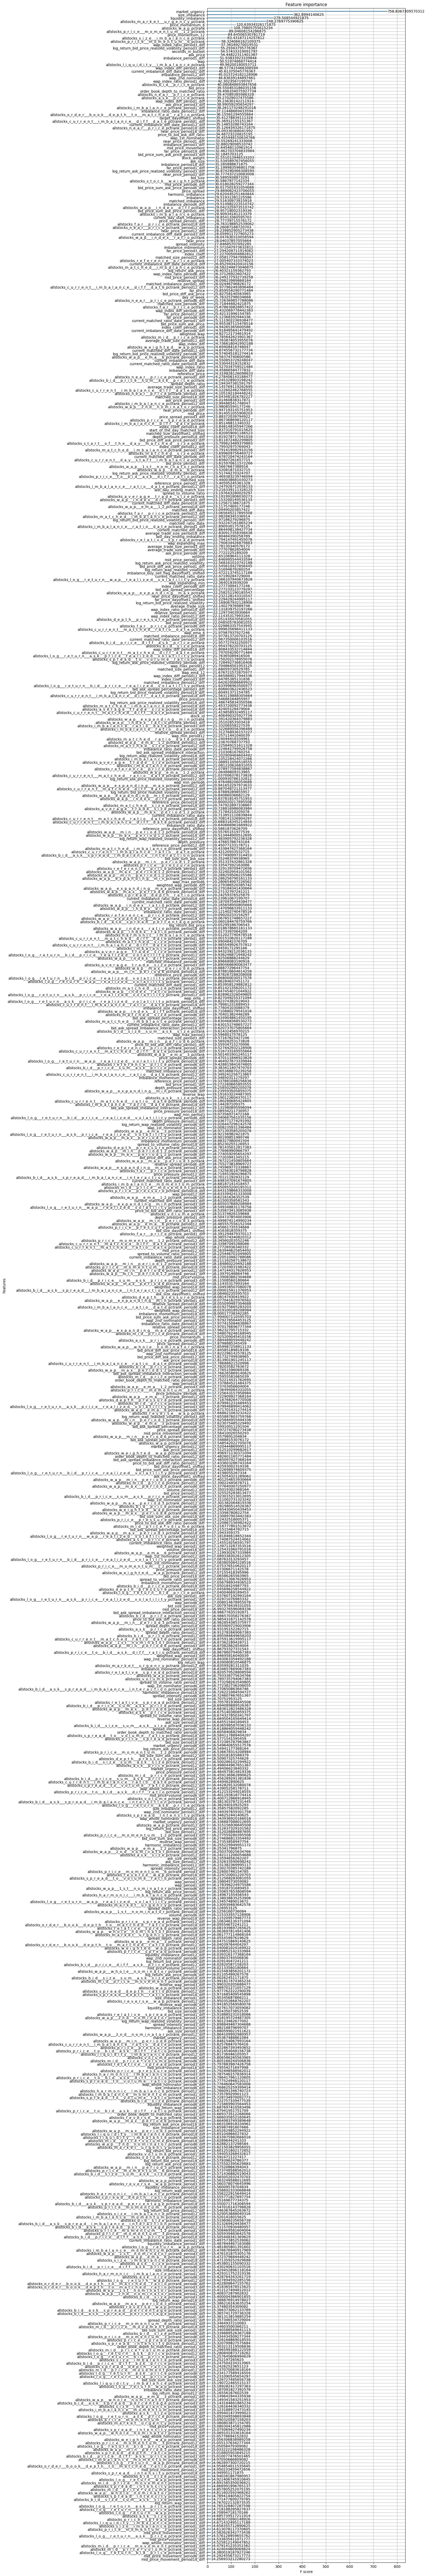

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10,130))
xgb.plot_importance(model, importance_type="gain", ax=ax)
plt.savefig('foo.png', bbox_inches='tight')

In [20]:
del model

In [17]:
d_train = xgb.DMatrix(whole_df[features], whole_df[target])
model = xgb.train(xgb_param, d_train, num_boost_round=4500)
model.save_model(f'model_full.json')

In [ ]:
pred_df[[   
    'fold1',
    'fold2',
    'fold3',
    'fold4'
]] = whole_df[[   
    'fold1',
    'fold2',
    'fold3',
    'fold4'
]]

In [ ]:
pred_df.to_csv("oof.csv", index=False)

In [19]:
kagglelast_df = whole_df[(whole_df.date_id==480) & (whole_df.seconds_in_bucket==540)]\
        .reset_index(drop=True)[model.feature_names]

d_sub = xgb.DMatrix(kagglelast_df[model.feature_names])
valpreds = model.predict(d_sub)
weighted_prediction = valpreds * kagglelast_df.stock_weight.values
valpreds -= weighted_prediction.sum() / kagglelast_df.stock_weight.sum()
valpreds = pd.Series(valpreds).clip(-64, 64)
display(valpreds)

0     -1.812832
1     -0.023734
2      0.721962
3     -1.565173
4     -1.431554
         ...   
195   -1.939740
196   -1.899584
197    0.256825
198    0.707631
199   -4.627436
Length: 200, dtype: float32

In [21]:
kagglesub_df = pd.read_parquet("kagglesub.pqt")["target"]
kagglesub_df

0     -1.812833
1     -0.023734
2      0.721961
3     -1.565173
4     -1.431554
         ...   
195   -1.939740
196   -1.899584
197    0.256825
198    0.707630
199   -4.627435
Name: target, Length: 200, dtype: float32

In [23]:
np.abs(kagglesub_df - valpreds).mean()

6.698072e-07

In [ ]:
# preds = model.predict(df.loc[validation_idx][features])

In [ ]:
# pred_tgt = (((preds / df.loc[validation_idx]["wap"]) -\
# (df.loc[validation_idx]["t60_index_coeff"] / df.loc[validation_idx]["index_coeff"])) * 10000)

In [ ]:
# (df.loc[validation_idx]["target"] - pred_tgt).abs().mean()